In [2]:
%load_ext autoreload
%autoreload 2

# Systematically Improving Your Rag Application

> If you haven't already, please run `1. Synthetic-Transactions.ipynb` to generate a dataset of synthetic transactions that you'll need to use for this notebook. You will need at least 256 examples to kick off a fine-tuning job.

## Why start with a managed Re-Ranker?

We want to start with a managed re-ranker early on, especially if we have a limited amount of data. This is because

1. **Re-rankers are more data efficient** : In situations where data is scarce, re-rankers are very effective with a small amount of training examples. This is because unlike embedding models, they only need to learn how to optimize the ranking of a small set of candidates.

2. **Easy to Integrate** : As more data becomes available, we can fine-tune our re-ranker or use it as a second step of our retrieval process. This allows us to progressively improve the quality of our results without having to overhaul our entire setup or re-embed all of our candidates from scratch. 

3. **Quick to Implement** : Using a hosted service like Cohere allows us to save valuable engineering time and resources. We don't have to worry about the underlying deployment infrastructure or focus on other considerations such as hyper-parameter tuning, context-length limitations etc which an open source model would require us to handle. This allows us to focus instead of experimenting and iterating quickly, enabling us to learn what works best for our application by looking at Recall and Mean Reciprocal Rank(MRR).

In short, we recommend starting with a managed re-ranker early on because it's the fastest way to achieve the biggest performance improvements. We recommend using Cohere because they have one of the best re-ranker models in the industry right now and it integrates seamlessly with `lancedb`'s search api.


## Why do we need Hard Negatives?

In this notebook, we'll be mining for hard negatives by providing categories that are distinct yet challenging for the model to differentiate from the transaction's actual label. This approach helps the model understand subtle distinctions when ranking potential categories.

We can see an example of this below where we have a query about Google , a relevant passage about Google Maps and an irrelevant passage about Napoli's famous dishes. We'd ideally want our model to rank the relevant passage higher than the irrelevant one.

<img src="./data/hard_negatives.png" width="600"/>

We want hard negatives because 

1. **Improves Discriminative Ability** : By providing the model with non-relevant examples, hard negatives train the re-ranker to discriminate between relevant examples and similar but irrelevant results. 

2. **Robustness to Noise** : Hard negatives allow our model to learn to ignore noisy results that are similar but irrelevant. This helps to improve the overall quality of our results.

3. **Effecient use of limited data**: In situations where data is scarce, hard negatives allow us to make the most out of the limited data we have. This is because we can use a small amount of data to train our model to effectively distinguish between relevant and irrelevant results.

More concretely, in our dataset, we would process each dataset item as follows.

Query
```
Name : Ayden
Category: Financial Software
Department: Finance
Location: Berlin, DE
Amount: 1273.45
Card: Enterprise Technology Services
Trip Name: unknown 
```

Relevant Passages
```
Subscription & Revenue Infrastructure
```

Hard Negatives
```
Office Equipment Maintenance
Office Supplies & Stationery
Human Resource
```

We're using a relatively simple approach here by randomly sampling other categories from our dataset. In practice, you might want to adopt a more sophisticated approach by using methods such as  

1. **Cosine Similarity** : Only choosing negatives that have high similarity scores with the positive category
2. **Adverserial Sampling** : Using language models to identify hard negatives and generate more off
3. **K-Means Clustering** : Clustering categories and selecting negatives from the same cluster to increase discriminative ability of our re-ranker

# Starting Our Finetuning process

## Preparing our Dataset

In our previous notebook, we initialized our dataset and split it into train/eval sets. We'll be using the training set here and mining for hard negatives to create a new finetuning dataset. 

We want to use `Pydantic` here to define a single instance of our finetuning data because it allows us to easily convert our data into the format that Cohere expects. Additionally, as our fine-tuning data gets more complex, it provides an easy way to add in custom validation logic.


In [3]:
from braintrust import init_dataset

dataset = init_dataset(project="fine-tuning", name="Synthetic Transactions")


def get_dataset_split(split: str, dataset):
    return [
        {
            "input": transaction["input"],
            "expected": transaction["expected"],
        }
        for transaction in dataset
        if transaction["metadata"]["split"] == split
    ]


train_data = get_dataset_split("train", dataset)
eval_data = get_dataset_split("eval", dataset)

In [3]:
from pydantic import BaseModel


# Define Pydantic model to store our finetuning data
class FinetuneItem(BaseModel):
    query: str
    relevant_passages: list[str]
    hard_negatives: list[str]


# Get all the labels in our dataset
labels = set([transaction["expected"][0] for transaction in train_data])

In [8]:
import random

finetuning_data = [
    FinetuneItem(
        query=transaction["input"],
        relevant_passages=[transaction["expected"][0]],
        hard_negatives=random.sample(
            [label for label in labels if label != transaction["expected"][0]], k=4
        ),
    )
    for transaction in train_data
    # Generate 2 samples with 4 hard negatives each for each transaction
    for _ in range(2)
]

with open("./data/cohere_finetune.jsonl", "w") as f:
    for item in finetuning_data:
        f.write(item.model_dump_json() + "\n")

## Uploading Our Dataset

A reminder that the fine-tuning itself will take around 1 hour to a day so you'll need to come back to this notebook later down the line when this is done.

Once the dataset has a status `validated`, we can kick off our fine-tuning job.

In [9]:
import cohere

co = cohere.ClientV2()

reranked_dataset = co.datasets.create(
    name="Synthetic Transactions Finetune",
    data=open("./data/cohere_finetune.jsonl", "rb"),
    type="reranker-finetune-input",
)

co.wait(reranked_dataset).dataset.validation_status


...
...
...


'validated'

## Finetuning Our model

Now that we've uploaded our dataset, we can kick off our fine-tuning job. Make sure to indicate that you're doing a re-ranker finetune when creating the job.

In [25]:
from cohere.finetuning import BaseModel, FinetunedModel, Settings

finetune_request = co.finetuning.create_finetuned_model(
    request=FinetunedModel(
        name="finetuned-cohere-reranker",
        settings=Settings(
            base_model=BaseModel(base_type="BASE_TYPE_RERANK"),
            dataset_id=reranked_dataset.id,
        ),
    )
)

In [29]:
response = co.finetuning.get_finetuned_model(finetune_request.finetuned_model.id)
response.finetuned_model.status

'STATUS_READY'

# Benchmarking our Model

We want to quantify the improvement that fine-tuning a model gets us. In order to do so, we'll be using the same retrieval evals as before to benchmark our fine-tuned model. Since we're building a model here that will suggest relevant categories for a given transaction, we'll be measuring the following two metrics.    

- Recall : Whether the correct category is in the top N results
- MRR : The mean reciprocal rank of the correct category in the top N results

We want to mainly measure two things

- How much of an improvement does a fine-tuned model get us over a pure embedding based approach
- How does the fine-tuned model perform against the default Cohere re-ranker

In order to do so, we'll be benchmarking our fine-tuned model against the default text-embedding-3-small model as well as the default Cohere re-ranker. We'll use `braintrust` here to run our evaluations and compare the results between our different configurations since it's where we've stored our evaluation data and provides an easy way to share our results with others.



In [1]:
import lancedb

db = lancedb.connect("./lancedb")
table = db.open_table("categories")

In [5]:
from braintrust import Eval, Score
from lancedb.rerankers import CohereReranker
from helpers import get_metrics_at_k, task


def evaluate_braintrust(input, output, **kwargs):
    metrics = get_metrics_at_k(metrics=["mrr", "recall"], sizes=[1, 3, 5])
    return [
        Score(
            name=metric,
            score=score_fn(output, kwargs["expected"]),
            metadata={"query": input, "result": output, **kwargs["metadata"]},
        )
        for metric, score_fn in metrics.items()
    ]

rerankers = [
    # Remember to replace this with your fine-tuned model id
    CohereReranker(model_name="0486d248-8476-40f6-a5bf-1ef6fd8a65dd-ft"),
    CohereReranker(model_name="rerank-english-v3.0"),
    None,
]

results = []

for reranker in rerankers:
    results.append(
        await Eval(
            "fine-tuning",  # Replace with your project name
            data=eval_data, # We're using the eval data here to do the benchmarking
            task=lambda query: task(user_query=query, table=table, reranker=reranker, max_k=25),  # Replace with your LLM call
            scores=[evaluate_braintrust],
        )
    )

Experiment fine-tuning-1731504205 is running at https://www.braintrust.dev/app/567/p/fine-tuning/experiments/fine-tuning-1731504205
fine-tuning (data): 66it [00:00, 66576.25it/s]


fine-tuning (tasks):   0%|          | 0/66 [00:00<?, ?it/s]


=========================SUMMARY=========================
fine-tuning-1731504205 compared to fine-tuning-1731504166:
72.73% 'mrr@1'    score
81.31% 'mrr@3'    score
81.62% 'mrr@5'    score
72.73% 'recall@1' score
90.91% 'recall@3' score
92.42% 'recall@5' score

4.48s (+432.36%) 'duration'	(0 improvements, 66 regressions)

See results for fine-tuning-1731504205 at https://www.braintrust.dev/app/567/p/fine-tuning/experiments/fine-tuning-1731504205


Experiment fine-tuning-1731504218 is running at https://www.braintrust.dev/app/567/p/fine-tuning/experiments/fine-tuning-1731504218
fine-tuning (data): 66it [00:00, 28482.77it/s]


fine-tuning (tasks):   0%|          | 0/66 [00:00<?, ?it/s]


=========================SUMMARY=========================
fine-tuning-1731504218 compared to fine-tuning-1731504205:
22.73% (-50.00%) 'mrr@1'    score	(2 improvements, 35 regressions)
25.76% (-55.56%) 'mrr@3'    score	(3 improvements, 43 regressions)
27.20% (-54.42%) 'mrr@5'    score	(3 improvements, 44 regressions)
22.73% (-50.00%) 'recall@1' score	(2 improvements, 35 regressions)
30.30% (-60.61%) 'recall@3' score	(0 improvements, 40 regressions)
36.36% (-56.06%) 'recall@5' score	(0 improvements, 37 regressions)

4.90s (+42.16%) 'duration'	(33 improvements, 33 regressions)

See results for fine-tuning-1731504218 at https://www.braintrust.dev/app/567/p/fine-tuning/experiments/fine-tuning-1731504218


Experiment fine-tuning-1731504232 is running at https://www.braintrust.dev/app/567/p/fine-tuning/experiments/fine-tuning-1731504232
fine-tuning (data): 66it [00:00, 33693.29it/s]


fine-tuning (tasks):   0%|          | 0/66 [00:00<?, ?it/s]


=========================SUMMARY=========================
fine-tuning-1731504232 compared to fine-tuning-1731504218:
40.91% (+18.18%) 'mrr@1'    score	(19 improvements, 7 regressions)
49.75% (+23.99%) 'mrr@3'    score	(28 improvements, 8 regressions)
52.47% (+25.28%) 'mrr@5'    score	(33 improvements, 8 regressions)
40.91% (+18.18%) 'recall@1' score	(19 improvements, 7 regressions)
62.12% (+31.82%) 'recall@3' score	(25 improvements, 4 regressions)
74.24% (+37.88%) 'recall@5' score	(26 improvements, 1 regressions)

2.12s (-278.10%) 'duration'	(66 improvements, 0 regressions)

See results for fine-tuning-1731504232 at https://www.braintrust.dev/app/567/p/fine-tuning/experiments/fine-tuning-1731504232


# Results Analysis and Next Steps

Now that we've run our evaluations, let's take a closer look at the results. We want to compare the performance of our fine-tuned model against the default Cohere re-ranker as well as the default vector search baseline without a re-ranker.

In [7]:
import pandas as pd
scores = []

for result in results:
    result_scores = {}
    for score_name, score in result.summary.scores.items():
        result_scores[score_name] = score.score
    scores.append(result_scores)

df = pd.DataFrame(scores,index=["Fine-Tuned Reranker", "Default Reranker", "No Reranker"])
df.round(2)

,mrr@1,mrr@3,mrr@5,recall@1,recall@3,recall@5
Fine-Tuned Reranker,0.73,0.81,0.82,0.73,0.91,0.92
Default Reranker,0.23,0.26,0.27,0.23,0.30,0.36
No Reranker,0.41,0.50,0.52,0.41,0.62,0.74


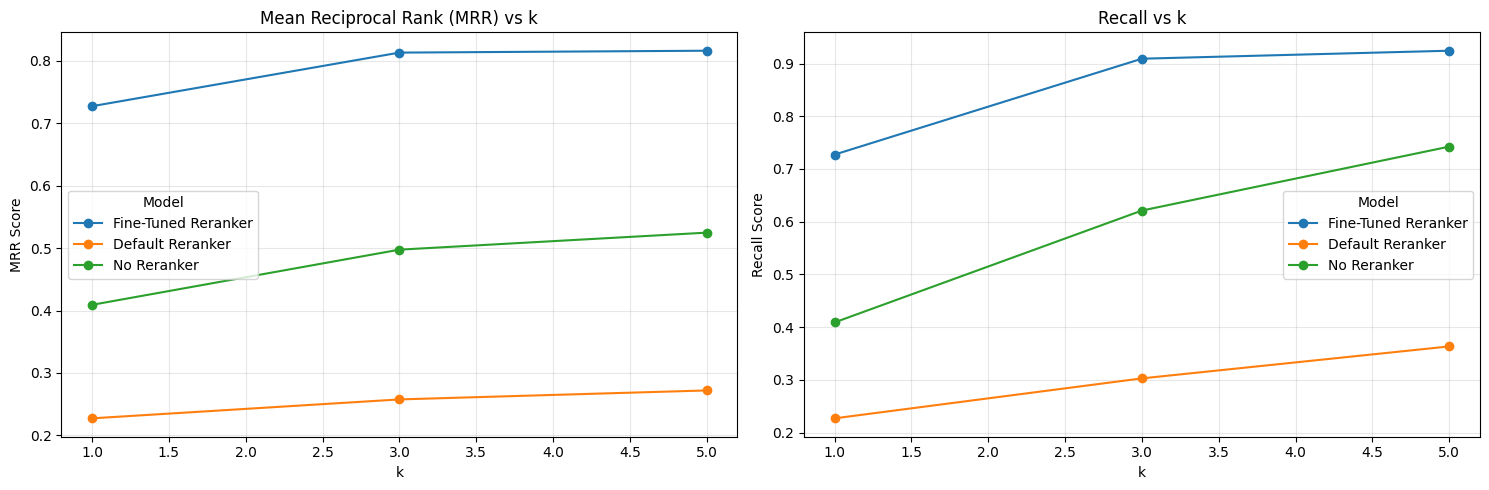

In [8]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Extract k values from column names and convert to numeric
k_values = [int(col.split('@')[1]) for col in df.columns if col.startswith('mrr')]

# Plot MRR values as lines
mrr_cols = [f'mrr@{k}' for k in k_values]
for model in df.index:
    ax1.plot(k_values, df.loc[model, mrr_cols], marker='o', label=model)
ax1.set_title('Mean Reciprocal Rank (MRR) vs k')
ax1.set_xlabel('k')
ax1.set_ylabel('MRR Score')
ax1.legend(title='Model')
ax1.grid(True, alpha=0.3)

# Plot Recall values as lines
recall_cols = [f'recall@{k}' for k in k_values]
for model in df.index:
    ax2.plot(k_values, df.loc[model, recall_cols], marker='o', label=model)
ax2.set_title('Recall vs k')
ax2.set_xlabel('k')
ax2.set_ylabel('Recall Score')
ax2.legend(title='Model')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()




With just 256 examples, our fine-tuned reranker showed a 60%+ average increase in recall and a 49% average increase in mean reciprocal rank (MRR) compared to the text-embedding-3-small model. On the contrary, using the default Cohere re-ranker actually degraded performance at the cost of increased latency.

Ultimately when you have a limited amount of data, fine-tuning a reranker is a no-brainer. It allows you to outperform the default model and get a good return on your investment. When looking to fine-tune it on your own data, some key considerations to look at are

1. **Model Selection** : We chose to finetune on the cohere re-rankers but they have english and multi-lingual options to choose from. There are also other managed providers such as Jina that offer re-ranker models. It's important to experiment and find one that works for you
2. **Dataset Quality** : In our example here, we mined for hard negatives by simply randomly selecting other categories. You might want to adopt a more sophisticated approach such as looking at cosine similarity or getting a language model involved.

In the next notebook, we'll look at how we might fine-tune an open source model using the Sentence Transformers library. We'll need to manage our hyper-parameters, loss functions and training loop but at the same time, be able to squeeze out significantly more performance out of our model. 